In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt

In [2]:
device = 'cuda:1' if torch.cuda.is_available() else 'i[[[[]]]]'
print(device)

cuda:1


In [3]:
# Define transforms for data augmentation and normalization
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # Ensure images are single-channel (grayscale)
    transforms.Resize((48, 48)),                 # Resize to match input size
    transforms.ToTensor(),                       # Convert image to tensor
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize pixel values to [-1, 1]
])

# Path to your dataset folders
train_dir = "./data/FER/train"  # Update with the path to the train folder
test_dir = "./data/FER/test"    # Update with the path to the test folder

# Create datasets
train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
test_dataset = datasets.ImageFolder(root=test_dir, transform=transform)

In [4]:
BATCH_SIZE = 512

In [5]:
# Define the split sizes (e.g., 80% train, 20% validation)
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size

# Split the dataset into train and validation subsets
train_subset, val_subset = random_split(train_dataset, [train_size, val_size])

# Create data loaders for train, validation, and test sets
train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
val_loader = DataLoader(val_subset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

# Print sizes of each dataset
print(f"Number of Training Samples: {len(train_subset)}")
print(f"Number of Validation Samples: {len(val_subset)}")
print(f"Number of Test Samples: {len(test_dataset)}")

Number of Training Samples: 22967
Number of Validation Samples: 5742
Number of Test Samples: 7178


In [6]:
for step, (images, labels) in enumerate(train_loader):
    # images: Tensor of shape [batch_size, 1, 48, 48]
    # labels: Tensor of shape [batch_size] containing label indices
    print(step, images.shape, labels.shape)
    break

0 torch.Size([512, 1, 48, 48]) torch.Size([512])


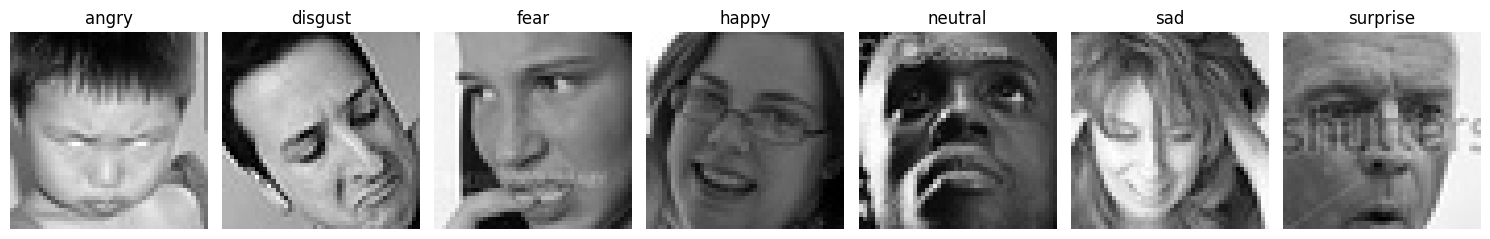

In [7]:
# Create a dictionary to store one image per label
images_per_label = {}

# Loop through the dataset to find one image per label
for img, label in train_dataset:
    if label not in images_per_label:
        images_per_label[label] = img
    if len(images_per_label) == len(train_dataset.classes):  # Break once all labels are collected
        break

# Ensure we only handle 7 labels
num_labels = len(images_per_label)
fig, axes = plt.subplots(1, num_labels, figsize=(15, 5))

# Plot one image per label
for i, (label, img) in enumerate(images_per_label.items()):
    ax = axes[i]
    ax.imshow(img.squeeze(), cmap='gray')
    ax.set_title(train_dataset.classes[label])  # Use class names instead of indices
    ax.axis('off')

plt.tight_layout()
plt.show()


In [8]:
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        
        # Convolutional layers
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.dropout1 = nn.Dropout2d(0.25)  # Dropout after conv1

        self.conv2 = nn.Conv2d(64, 128, kernel_size=5, padding=2)
        self.bn2 = nn.BatchNorm2d(128)
        self.dropout2 = nn.Dropout2d(0.2)  # Dropout after conv2
        
        self.conv3 = nn.Conv2d(128, 512, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(512)
        self.dropout3 = nn.Dropout2d(0.25)  # Dropout after conv3
        
        self.conv4 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(512)
        self.dropout4 = nn.Dropout2d(0.25)  # Dropout after conv4
        
        # Fully connected layers
        self.fc1 = nn.Linear(512 * 3 * 3, 256)
        self.bn_fc1 = nn.BatchNorm1d(256)
        self.dropout_fc1 = nn.Dropout(0.25)
        
        self.fc2 = nn.Linear(256, 512)
        self.bn_fc2 = nn.BatchNorm1d(512)
        self.dropout_fc2 = nn.Dropout(0.25)
        
        self.fc3 = nn.Linear(512, 7)  # 7 output classes (emotions)
        
        # Xavier initialization
        self._initialize_weights()

    def forward(self, x):
        # First Conv Layer
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.max_pool2d(x, 2)  # 48x48 -> 24x24
        x = self.dropout1(x)  # Apply dropout
        
        # Second Conv Layer
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.max_pool2d(x, 2)  # 24x24 -> 12x12
        x = self.dropout2(x)  # Apply dropout
        
        # Third Conv Layer
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.max_pool2d(x, 2)  # 12x12 -> 6x6
        x = self.dropout3(x)  # Apply dropout
        
        # Fourth Conv Layer
        x = F.relu(self.bn4(self.conv4(x)))
        x = F.max_pool2d(x, 2)  # 6x6 -> 3x3
        x = self.dropout4(x)  # Apply dropout

        # Flatten
        x = x.view(x.size(0), -1)  # Flatten the tensor: 512 * 3 * 3
        
        # Fully connected layers
        x = F.relu(self.bn_fc1(self.fc1(x)))
        x = self.dropout_fc1(x)  # Apply dropout
        
        x = F.relu(self.bn_fc2(self.fc2(x)))
        x = self.dropout_fc2(x)  # Apply dropout
        
        x = self.fc3(x)  # Output layer
        
        return x, F.log_softmax(x, dim=1)  # Raw logits, Log-Softmax for normalized probabilities

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)


In [9]:
# Hyperparameters
lr = 0.01
batch_size = BATCH_SIZE
num_epoch = 1000
classes = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

In [10]:
cnn_model = SimpleCNN()
cnn_model = cnn_model.to(device)
optimizer = torch.optim.SGD(cnn_model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)
loss_fn = nn.CrossEntropyLoss()

print(cnn_model)

SimpleCNN(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout2d(p=0.25, inplace=False)
  (conv2): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout2): Dropout2d(p=0.2, inplace=False)
  (conv3): Conv2d(128, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout3): Dropout2d(p=0.25, inplace=False)
  (conv4): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout4): Dropout2d(p=0.25, inplace=False)
  (fc1): Linear(in_features=4608, out_features=256, bias=True)
  (bn_fc1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, t

/home/minnb/.local/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [11]:
# Dummy input to test the model
dummy_input = torch.randn(8, 1, 48, 48)  # Batch size 8, 1 channel, 48x48 image
output = cnn_model(dummy_input.to(device))
print("Output shape:", output[0].shape)  # Should output a shape of (1, 7) assuming 7 classes

Output shape: torch.Size([8, 7])


In [12]:
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
test_losses = []
test_accuracies = []

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
test_losses = []
test_accuracies = []

# Early stopping parameters
best_val_loss = float('inf')  # Best validation loss initialized to infinity
patience = 10  # Number of epochs to wait for improvement
early_stop_counter = 0  # Counter to track patience

In [13]:
def train_and_validate(num_epochs):
    global best_val_loss, early_stop_counter

    for epoch in range(num_epochs):
        # Training phase
        cnn_model.train()  # Sets model to training mode
        train_corr, train_total, train_running_loss = 0, 0, 0  # Counters for training

        for step, (data, y) in enumerate(train_loader):  # Loops over batches in train_loader
            data, y = data.to(device), y.to(device)
            optimizer.zero_grad()  # Resets gradients
            _, logits = cnn_model(data)  # Forward pass
            loss = loss_fn(logits, y)  # Compute loss
            loss.backward()  # Backward pass (compute gradients)
            optimizer.step()  # Optimizer step (update parameters)

            # Compute predictions and track metrics
            y_pred = torch.argmax(logits, 1)  # Predicted class
            train_corr += torch.sum(torch.eq(y_pred, y).float()).item()  # Correct predictions
            train_total += len(data)  # Total examples
            train_running_loss += loss.item()  # Accumulate loss

        # Calculate average loss and accuracy for this epoch
        train_epoch_loss = train_running_loss / len(train_loader)
        train_epoch_accuracy = train_corr / train_total

        # Append training metrics for plotting
        train_losses.append(train_epoch_loss)
        train_accuracies.append(train_epoch_accuracy)

        # Validation phase
        cnn_model.eval()  # Set model to evaluation mode
        val_corr, val_total, val_running_loss = 0, 0, 0

        with torch.no_grad():  # Disable gradient computation
            for data, y in val_loader:
                data, y = data.to(device), y.to(device)
                _, logits = cnn_model(data)
                loss = loss_fn(logits, y)  # Compute validation loss
                y_pred = torch.argmax(logits, 1)
                val_corr += torch.sum(torch.eq(y_pred, y).float()).item()
                val_total += len(data)
                val_running_loss += loss.item()

        # Calculate average validation loss and accuracy
        val_epoch_loss = val_running_loss / len(val_loader)
        val_epoch_accuracy = val_corr / val_total

        # Append validation metrics for plotting
        val_losses.append(val_epoch_loss)
        val_accuracies.append(val_epoch_accuracy)

        # Step the LR scheduler
        scheduler.step(val_epoch_loss)  # Adjust LR based on validation loss

        print(f"Epoch [{epoch+1}/{num_epochs}] Train Loss: {train_epoch_loss:.4f}, Accuracy: {train_epoch_accuracy:.4f} | "
              f"Validation Loss: {val_epoch_loss:.4f}, Accuracy: {val_epoch_accuracy:.4f}")

        # Early stopping logic
        if val_epoch_loss < best_val_loss:
            best_val_loss = val_epoch_loss
            early_stop_counter = 0  # Reset counter if validation loss improves
            print(f"Validation loss improved. Saving model...")
            torch.save(cnn_model.state_dict(), 'best_model.pth')  # Save the model
        else:
            early_stop_counter += 1
            print(f"Validation loss did not improve. Early stop counter: {early_stop_counter}/{patience}")

        if early_stop_counter >= patience:
            print(f"Early stopping triggered. Stopping training.")
            break

    
####################################################################################################################
   
def test():
    cnn_model.eval()                                        # sets model to evalutaion mode
    test_corr, test_total, test_running_loss = 0, 0, 0
    with torch.no_grad():
        for step, (data, y) in enumerate(test_loader):
            data, y = data.to(device), y.to(device)
            _, logits = cnn_model(data)
            loss = loss_fn(logits, y)
            y_pred = torch.argmax(logits, 1)
            test_corr += torch.sum(torch.eq(y_pred, y).float()).item()
            test_total += len(data)
            test_running_loss += loss.item()
    # Calculate average loss and accuracy for this epoch
    epoch_loss = test_running_loss / len(test_loader)
    epoch_accuracy = test_corr / test_total

    # Append to lists for plotting
    test_losses.append(epoch_loss)
    test_accuracies.append(epoch_accuracy)

    print(f'Test Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}')

In [14]:
train_and_validate(num_epoch)

Epoch [1/1000] Train Loss: 2.1717, Accuracy: 0.1880 | Validation Loss: 1.8080, Accuracy: 0.2485
Validation loss improved. Saving model...
Epoch [2/1000] Train Loss: 2.0303, Accuracy: 0.2218 | Validation Loss: 1.7542, Accuracy: 0.2910
Validation loss improved. Saving model...
Epoch [3/1000] Train Loss: 1.9732, Accuracy: 0.2380 | Validation Loss: 1.7352, Accuracy: 0.3001
Validation loss improved. Saving model...
Epoch [4/1000] Train Loss: 1.9455, Accuracy: 0.2418 | Validation Loss: 1.7223, Accuracy: 0.3119
Validation loss improved. Saving model...
Epoch [5/1000] Train Loss: 1.9064, Accuracy: 0.2467 | Validation Loss: 1.7053, Accuracy: 0.3231
Validation loss improved. Saving model...
Epoch [6/1000] Train Loss: 1.8899, Accuracy: 0.2562 | Validation Loss: 1.6939, Accuracy: 0.3274
Validation loss improved. Saving model...
Epoch [7/1000] Train Loss: 1.8635, Accuracy: 0.2642 | Validation Loss: 1.6808, Accuracy: 0.3349
Validation loss improved. Saving model...
Epoch [8/1000] Train Loss: 1.8392,

In [15]:
test()

Test Loss: 1.1140, Accuracy: 0.5635


In [16]:
from sklearn.metrics import classification_report

def get_classification_report(model, data_loader, device, class_names):
    model.eval()  # Set model to evaluation mode
    all_preds = []
    all_labels = []

    with torch.no_grad():  # Disable gradient computation
        for data, labels in data_loader:
            data, labels = data.to(device), labels.to(device)
            _, logits = model(data)  # Forward pass
            preds = torch.argmax(logits, dim=1)  # Get predicted class
            all_preds.extend(preds.cpu().numpy())  # Collect predictions
            all_labels.extend(labels.cpu().numpy())  # Collect true labels

    # Generate the classification report
    report = classification_report(all_labels, all_preds, target_names=class_names)
    return report

# Example usage:
class_names = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']  # Replace with your class names
report = get_classification_report(cnn_model, test_loader, device, class_names)
print(report)


              precision    recall  f1-score   support

       angry       0.51      0.41      0.45       958
     disgust       0.37      0.51      0.43       111
        fear       0.45      0.16      0.23      1024
       happy       0.74      0.82      0.78      1774
     neutral       0.48      0.58      0.53      1233
         sad       0.42      0.49      0.45      1247
    surprise       0.66      0.78      0.71       831

    accuracy                           0.56      7178
   macro avg       0.52      0.54      0.51      7178
weighted avg       0.55      0.56      0.54      7178



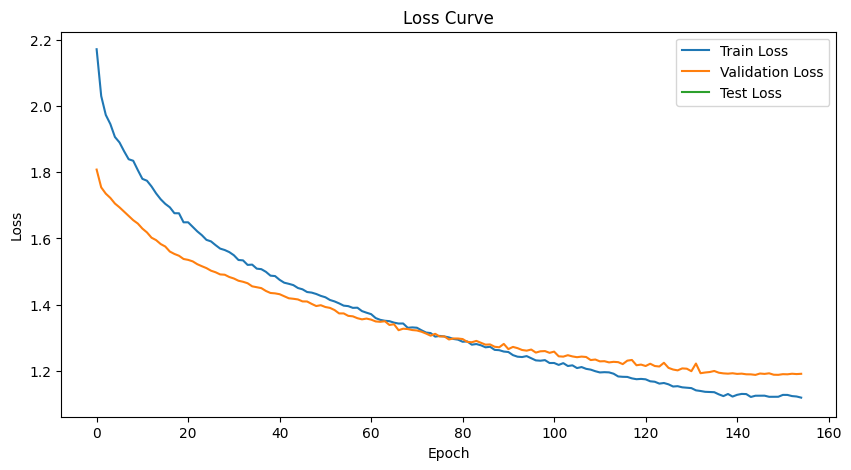

In [17]:
# Plot the training and test loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

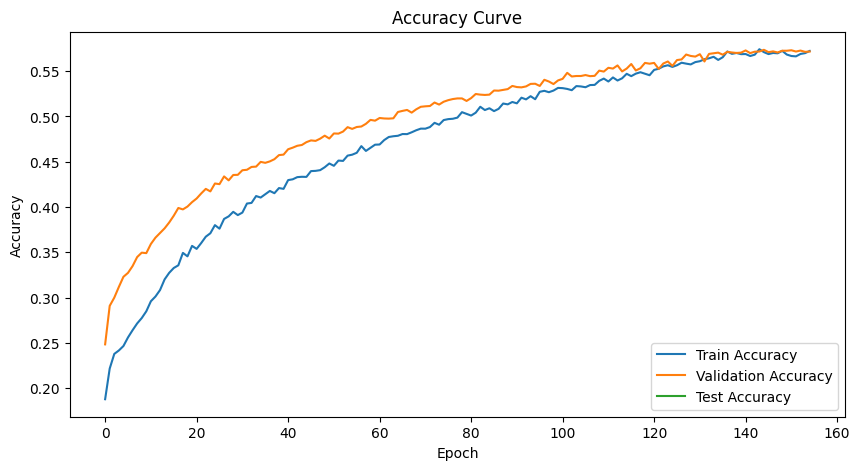

In [18]:
# Plot the training and test accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

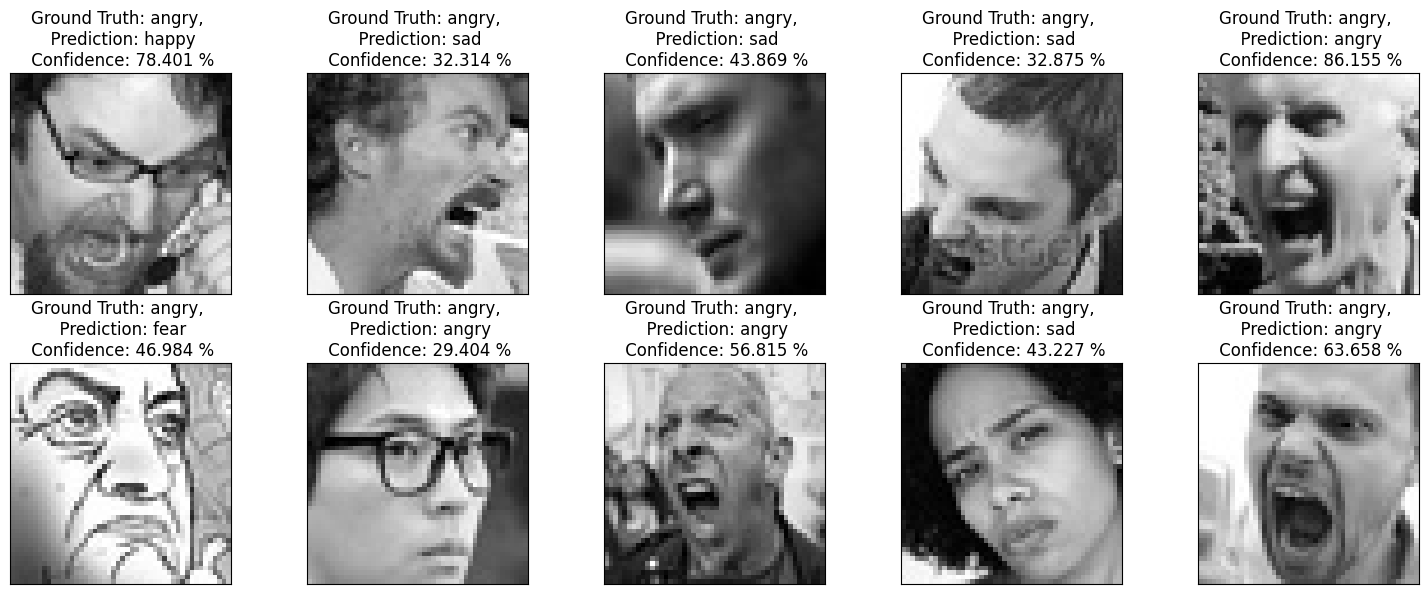

In [19]:
cnn_model.eval()
data, y = next(iter(test_loader))

# 1. push the data to the selected device
data, y = data.to(device), y.to(device)

# 2. feed the data into the model and the model makes predictions
_, logits = cnn_model(data)   # raw prediction before applying softmax ; unnormalised scores for each class

# 3. get the class with highest prob.
y_pred = torch.argmax(logits, 1) # finds the index of the class with the highest value (i.e., the predicted class) along dimension 1,

get_prob = torch.nn.Softmax(dim=1) # converts logits into probabilities that sums to 1
prob = get_prob(logits)            # prob is a tensor where each row corresponds to a sample, and each column contains the probability of that sample belonging to a particular class.

# Plot 
fig = plt.figure(figsize=(15,6))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(data[i].cpu().detach().numpy().reshape((48,48)), cmap='gray')
    
    # detach(): Detaches the tensor from the computation graph, so no gradients are tracked.
    # cpu(): Moves the tensor back to the CPU (important if you're using a GPU).
    # numpy(): Converts the tensor to a NumPy array.
    
    plt.title(f"Ground Truth: {classes[y[i].cpu().detach().numpy()]}, \n  Prediction: {classes[y_pred[i].cpu().detach().numpy()]} \n Confidence: {prob[i][y_pred[i]] * 100:.3F} %")
    plt.xticks([])
    plt.yticks([])
plt.tight_layout() # Adjusts the subplot parameters to make sure that subplots fit into the figure area nicely, avoiding overlaps.
plt.show()